In [28]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle
import os
%matplotlib inline

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

from utils import calibrate_camera, show_img, view_imgs, binary_threshold

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Camera calibration
In this part, we calibrate our camera using images from `camera_cal`, note that since doing camera calibration is slow, we dump it to a pickle file so that we can reuse later

In [6]:
img_files = np.sort(glob.glob('camera_cal/calibration*.jpg'))
Nx = 9
Ny = 5

# do camera calibration if we have done it
if not os.path.isfile('camera_calib.pkl'):
    img_WH, mtx, dist, rvecs, tvecs = calibrate_camera(img_files, Nx, Ny)
    with open('camera_calib.pkl', 'wb') as f:
        cam_calib = {'img_WH' : img_WH,
                     'mtx'    : mtx,
                     'dist'   : dist,
                     'rvecs'  : rvecs,
                     'tvecs'  : tvecs}
        pickle.dump(cam_calib, f)
else:
    with open('camera_calib.pkl', 'rb') as f:
        cam_calib = pickle.load(f)
        img_WH, mtx, dist, rvecs, tvecs = [cam_calib[k] for k in ['img_WH', 'mtx', 'dist', 'rvecs', 'tvecs']]


Test the calirated camera

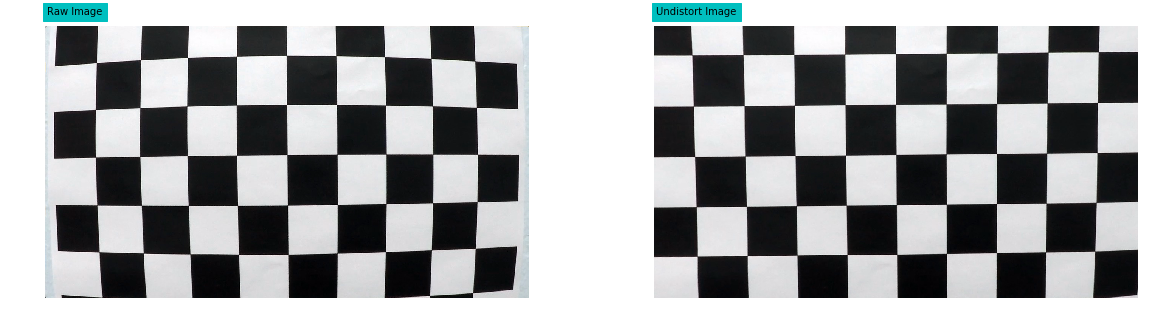

In [11]:
raw_img = cv2.imread(img_files[0])
undist_img = cv2.undistort(raw_img, mtx, dist, None, mtx)

view_imgs([raw_img, undist_img], ['Raw Image', 'Undistort Image'], figsize=(20,5))

## Pipeline (single images)
We will use the straight-lane-line image `test_images/straight_lines1.jpg` as test example.

### Undistort camera input
First let's look at undistort image

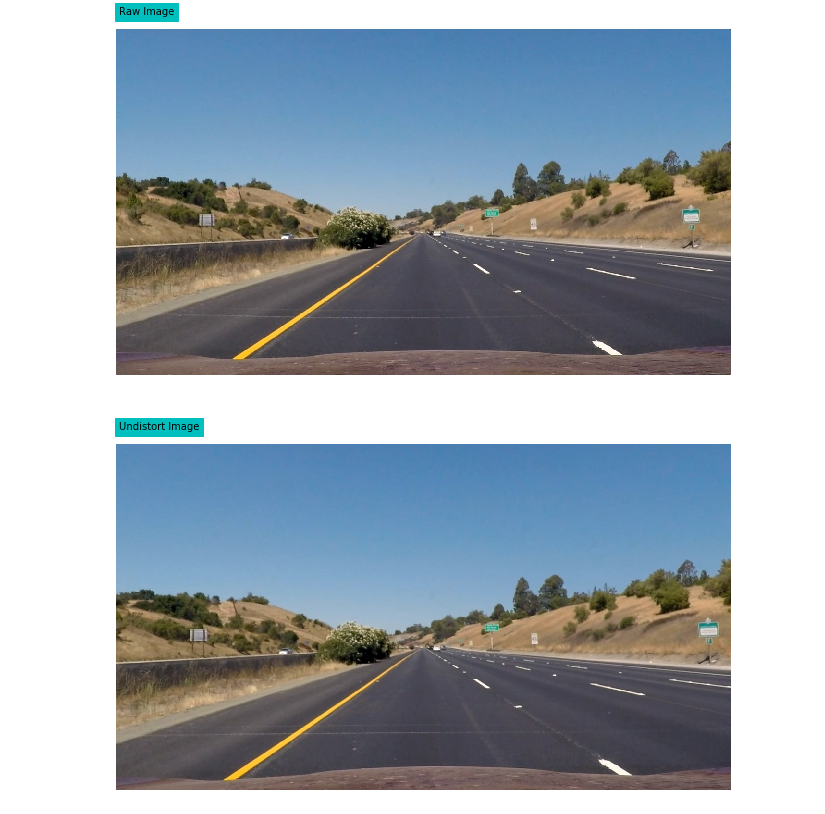

In [51]:
test_files = np.sort(glob.glob('test_images/*.jpg'))
raw_img = mpimg.imread(test_files[0])
undist_img = cv2.undistort(raw_img, mtx, dist, None, mtx)
view_imgs([raw_img, undist_img], ['Raw Image', 'Undistort Image'], figsize=(14,14), multi_col=False)

### Threshold binary images
We will apply a combination of

 * absolute Sobel threshold in x/y direction
 * magnitute Sobel threshold
 * direction threshold
 * color threshold using S-channel of HLS color-space

Here is the output of the above undistort image

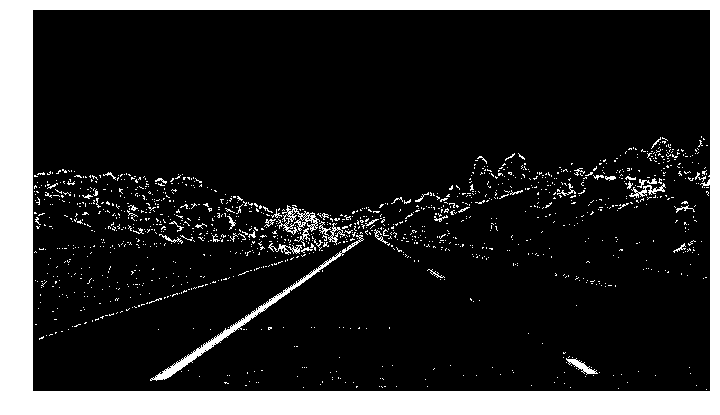

In [32]:
undist_img_bin = binary_threshold(undist_img)
show_img(undist_img_bin, None, cmap='gray', figsize=(14,7))

### Perspective transform
Now we want to view the road from bird-eye view

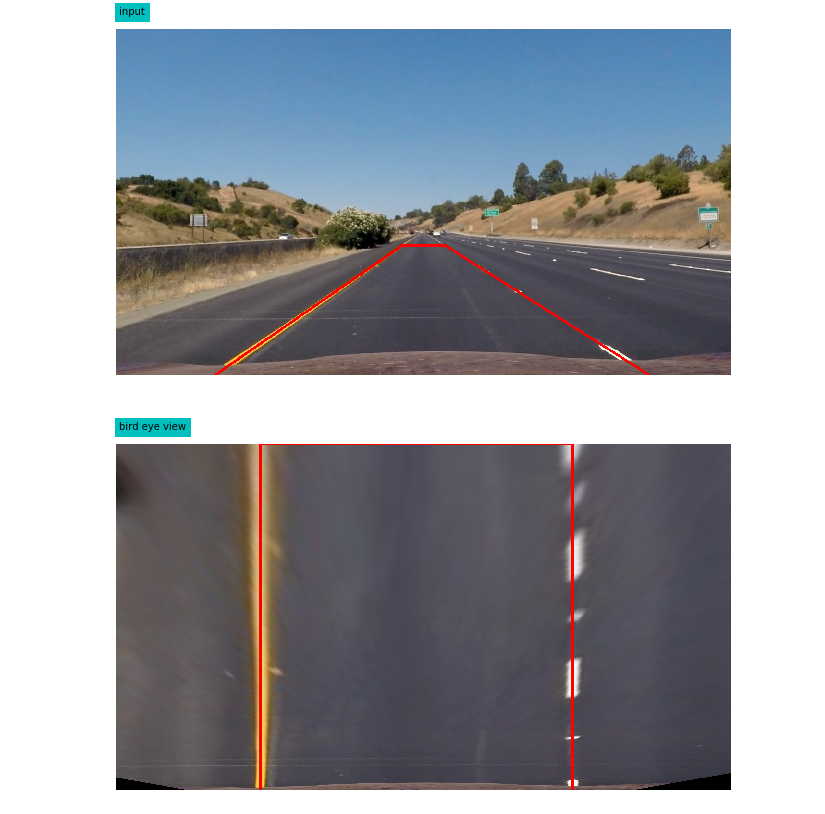

In [38]:
from utils import warper, src_points, dst_points

def view_perspective_trans(rgb_in):
    img = np.copy(rgb_in)
    warped = warper(img)        
    # draw line
    for i in range(3):
        cv2.line(img,    tuple(src_points[i]), tuple(src_points[i+1]), color=[255, 0, 0], thickness=4)
        cv2.line(warped, tuple(dst_points[i]), tuple(dst_points[i+1]), color=[255, 0, 0], thickness=4)
    
    view_imgs([img, warped], ['input', 'bird eye view'], figsize=(14,14), multi_col=False)
    
view_perspective_trans(undist_img)

And the perspective transformation if the binary image

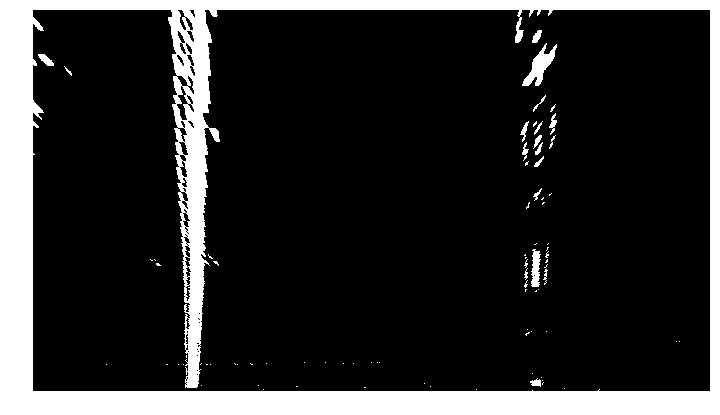

In [40]:
binary_wraped = warper(undist_img_bin)
show_img(binary_wraped, None, cmap='gray', figsize=(14,7))

### Find lane-line
We will use `find_lane_line_hist` or `find_lane_line_conv` for this task

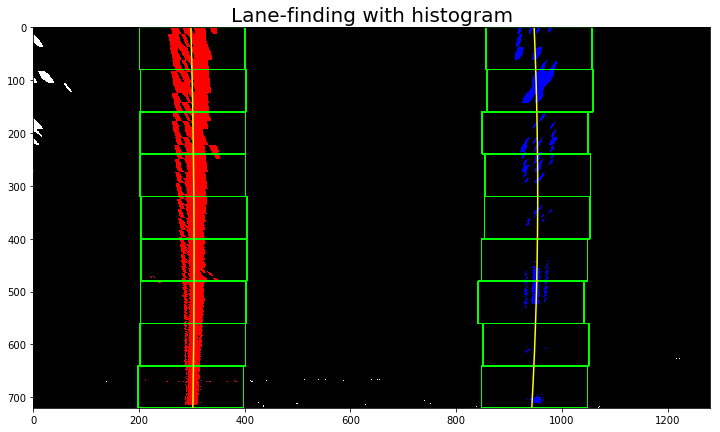

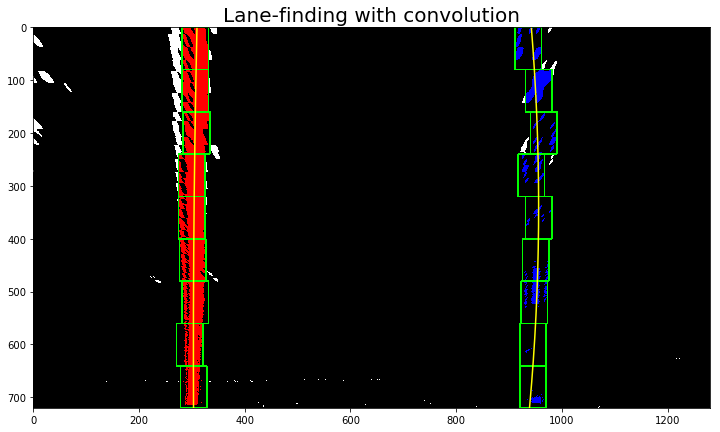

In [42]:
from lane_lines import find_lane_line_hist, find_lane_line_conv, visualize_lane_line

hist_lr_fits, hist_lr_points, hist_lr_windows = find_lane_line_hist(binary_wraped, 9, debug=True)
conv_lr_fits, conv_lr_points, conv_lr_windows = find_lane_line_conv(binary_wraped, 9, debug=True)

visualize_lane_line(binary_wraped, hist_lr_fits, hist_lr_points, hist_lr_windows, 'Lane-finding with histogram')
visualize_lane_line(binary_wraped, conv_lr_fits, conv_lr_points, conv_lr_windows, 'Lane-finding with convolution')

### Measuring curvature and car position
Using `measure_curvature` and `measure_offset` we obtain the following result for above input

In [45]:
left_fit, right_fit = hist_lr_fits
print(left_fit)
print(right_fit)

[ -3.03698051e-05   2.69762447e-02   2.98188034e+02]
[ -6.81216553e-05   4.28805066e-02   9.47634745e+02]


In [48]:
from utils import measure_curvature, measure_offset
img_W, img_H = img_WH
l_radius, r_radius = measure_curvature(img_H, hist_lr_fits)
pos_offset = measure_offset(img_H, img_W, hist_lr_fits)
print ('Left-right radius(m)   = {:.0f}, {:.0f}'.format(l_radius, r_radius))

if (pos_offset > 1e-2): 
    left_or_right = ' right '
elif (pos_offset < -1e-2):
    left_or_right = ' left '
else:
    left_or_right = ' '
print ('Car position offset(m) = {:.2f}{}of the center'.format(pos_offset, left_or_right))

Left-right radius(m)   = 5408, 2411
Car position offset(m) = 0.07 right of the center


### Draw lane-line onto the road
Now we draw our result onto the original road image

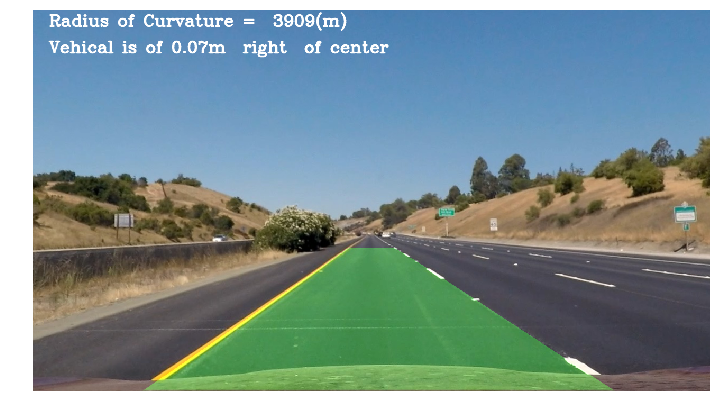

In [61]:
from lane_lines import draw_lane_area
lane_line_img = draw_lane_area(undist_img, binary_wraped, hist_lr_fits)
show_img(lane_line_img, None, figsize=(14,7))